In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

import time


In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, num_neighbours):
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)

  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


In [4]:
def get_convergent_barycenters(point_cloud, no_neighbours, initial_pt):    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)



        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            rem_indices = rem_set
            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Sphere

In [7]:
x, y, z = sp.symbols('x y z')

expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [8]:
# convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [9]:
#sample points
point_data = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [10]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [11]:
def random_sampling_from_pt_cloud(point_cloud, req_sample_size):
    
    point_cloud = torch.tensor(point_cloud)

    idx = np.random.randint(point_cloud.shape[0], size=req_sample_size)

    random_Sampled_point_cloud = point_cloud[idx,:]

    return random_Sampled_point_cloud

In [12]:
random_pts = random_sampling_from_pt_cloud(point_data, 50)

# Saved point clouds

In [13]:
PH_4_giving_118_points = torch.tensor([[-0.2651, -0.4322,  0.8619],
        [ 0.6898, -0.1667, -0.7045],
        [-0.0871,  0.5762, -0.8127],
        [ 0.3271,  0.8354, -0.4416],
        [-0.4939, -0.8345, -0.2442],
        [ 0.8764, -0.0884,  0.4734],
        [ 0.6431,  0.3164, -0.6974],
        [-0.7641,  0.3586,  0.5362],
        [ 0.8443, -0.5150,  0.1478],
        [-0.8358,  0.5454, -0.0636],
        [ 0.5026, -0.8323,  0.2340],
        [ 0.6222, -0.5194, -0.5857],
        [-0.2971, -0.6850, -0.6652],
        [ 0.4015,  0.6218,  0.6725],
        [ 0.2522, -0.8294,  0.4986],
        [ 0.2171,  0.0214,  0.9759],
        [-0.0700, -0.8402, -0.5377],
        [ 0.9435, -0.0952, -0.3173],
        [ 0.8551, -0.2600,  0.4485],
        [ 0.3975, -0.6439, -0.6538],
        [ 0.8225,  0.1326,  0.5531],
        [ 0.4227,  0.2453,  0.8725],
        [-0.1840,  0.9557,  0.2297],
        [ 0.4145, -0.6820,  0.6026],
        [ 0.8243, -0.2608,  0.5026],
        [ 0.9668,  0.2099, -0.1458],
        [ 0.6324,  0.6268, -0.4552],
        [-0.5974,  0.5781,  0.5558],
        [ 0.1723, -0.4043, -0.8983],
        [-0.5820,  0.0063,  0.8132],
        [ 0.4465,  0.4500,  0.7734],
        [-0.4023,  0.9135,  0.0609],
        [-0.0425,  0.8609, -0.5070],
        [-0.8300,  0.5377,  0.1485],
        [ 0.3652, -0.7955, -0.4836],
        [-0.8143,  0.4062,  0.4147],
        [ 0.4905, -0.8683,  0.0740],
        [ 0.6848,  0.4945,  0.5352],
        [ 0.5309,  0.8381,  0.1256],
        [ 0.5873,  0.5907,  0.5533],
        [-0.0060, -0.4782,  0.8783],
        [ 0.6837,  0.5609,  0.4669],
        [ 0.7228, -0.6044,  0.3349],
        [-0.1568, -0.1316, -0.9788],
        [ 0.6994,  0.0336,  0.7139],
        [ 0.7230,  0.5065,  0.4699],
        [-0.3459, -0.6676,  0.6593],
        [ 0.4704,  0.7033, -0.5331],
        [ 0.5289,  0.7670,  0.3633],
        [-0.2380,  0.5541,  0.7977],
        [ 0.0304, -0.3255, -0.9450],
        [-0.5841, -0.1504, -0.7976],
        [-0.7347,  0.6353,  0.2379],
        [-0.7347,  0.6353,  0.2379],
        [ 0.6890,  0.5570,  0.4638],
        [ 0.6761, -0.3858,  0.6276],
        [ 0.3593,  0.6688, -0.6509],
        [ 0.3584, -0.2212, -0.9070],
        [-0.5979,  0.1560,  0.7863],
        [ 0.3304,  0.6254,  0.7069],
        [ 0.7187, -0.1212,  0.6847],
        [ 0.7250, -0.6574,  0.2053],
        [ 0.7329, -0.2239, -0.6424],
        [-0.3673,  0.5145,  0.7749],
        [-0.1461,  0.7177, -0.6809],
        [-0.4623,  0.6707,  0.5800],
        [-0.4752, -0.3852,  0.7911],
        [ 0.7558, -0.5034, -0.4188],
        [ 0.2361, -0.7485, -0.6197],
        [-0.5480, -0.3019, -0.7801],
        [-0.6619,  0.5192, -0.5406],
        [ 0.1671, -0.9581,  0.2325],
        [ 0.0784,  0.7630,  0.6417],
        [-0.7134,  0.0824,  0.6959],
        [ 0.4677, -0.4491,  0.7613],
        [ 0.7457, -0.3840, -0.5445],
        [-0.1568, -0.1316, -0.9788],
        [ 0.4837,  0.6335,  0.6039],
        [ 0.8056,  0.5834, -0.1034],
        [-0.0976,  0.7299, -0.6765],
        [ 0.5915, -0.5043,  0.6291],
        [-0.3071,  0.4091,  0.8592],
        [ 0.3320, -0.5705, -0.7512],
        [ 0.5933, -0.1072,  0.7978],
        [-0.4140, -0.9004, -0.1336],
        [ 0.6000, -0.4937, -0.6295],
        [-0.2948, -0.3186, -0.9009],
        [-0.6782,  0.3486,  0.6469],
        [-0.0123,  0.2467, -0.9690],
        [ 0.8551, -0.2600,  0.4485],
        [-0.2764, -0.1855,  0.9430],
        [-0.7823,  0.5379,  0.3140],
        [ 0.1126,  0.6242, -0.7731],
        [-0.8196,  0.2976,  0.4896],
        [ 0.8569,  0.1656,  0.4882],
        [ 0.4060,  0.1070,  0.9076],
        [-0.7641,  0.3586,  0.5362],
        [ 0.7138, -0.3212,  0.6224],
        [ 0.4549, -0.5356,  0.7115],
        [-0.8131,  0.5561, -0.1721],
        [-0.4129,  0.7253,  0.5509],
        [ 0.4015,  0.6218,  0.6725],
        [ 0.7006, -0.1749,  0.6918],
        [ 0.6274, -0.0197,  0.7785],
        [ 0.7228, -0.5972, -0.3477],
        [-0.2528,  0.3951, -0.8832],
        [-0.5820,  0.0063,  0.8132],
        [ 0.9894,  0.0772, -0.1229],
        [ 0.3975, -0.6439, -0.6538],
        [ 0.6049, -0.4774,  0.6373],
        [-0.6771, -0.2742, -0.6829],
        [-0.3546,  0.4594, -0.8144],
        [-0.6579,  0.3467,  0.6685],
        [-0.9783,  0.1955, -0.0691],
        [ 0.4651, -0.4447, -0.7654],
        [-0.6307,  0.6143, -0.4742],
        [ 0.5900,  0.6465, -0.4837],
        [ 0.8293,  0.4805,  0.2852]], dtype=torch.float64)


PH_4_giving_90_points = torch.tensor([[-0.1210,  0.7159,  0.6876],
        [-0.7312,  0.1722, -0.6601],
        [-0.4904, -0.5329,  0.6896],
        [ 0.6511,  0.7252,  0.2240],
        [ 0.6096, -0.5450,  0.5756],
        [ 0.6551, -0.5750,  0.4902],
        [-0.6945,  0.5400, -0.4754],
        [-0.1827,  0.7725, -0.6082],
        [ 0.7859, -0.5960, -0.1649],
        [-0.7608, -0.0650,  0.6457],
        [ 0.4137,  0.4967, -0.7630],
        [ 0.3024,  0.8583, -0.4146],
        [-0.7184, -0.6856, -0.1174],
        [-0.8973,  0.2566, -0.3592],
        [ 0.4574, -0.2865,  0.8418],
        [ 0.1949, -0.8231, -0.5334],
        [ 0.6999,  0.0757, -0.7102],
        [ 0.4993, -0.4098, -0.7634],
        [-0.8133,  0.4905, -0.3131],
        [ 0.5743, -0.4540, -0.6812],
        [-0.2670, -0.9442, -0.1928],
        [-0.7433,  0.2239,  0.6304],
        [-0.4716,  0.5874,  0.6577],
        [-0.3596, -0.8892, -0.2828],
        [ 0.7243,  0.6359, -0.2667],
        [ 0.5446, -0.3511, -0.7616],
        [ 0.2903, -0.3011,  0.9083],
        [ 0.8486,  0.3174,  0.4233],
        [ 0.4561, -0.6369,  0.6216],
        [ 0.7314, -0.5244,  0.4360],
        [ 0.7051, -0.4774,  0.5243],
        [-0.4274, -0.7197, -0.5471],
        [ 0.9713,  0.1894,  0.1439],
        [ 0.3415, -0.8250,  0.4503],
        [ 0.4958,  0.7565,  0.4264],
        [ 0.7287, -0.6343,  0.2581],
        [-0.7195,  0.4256, -0.5488],
        [-0.5606, -0.6051, -0.5654],
        [ 0.8890,  0.3481, -0.2974],
        [-0.7538, -0.6567,  0.0230],
        [ 0.1974, -0.6249,  0.7553],
        [ 0.6441,  0.4491, -0.6193],
        [ 0.0092, -0.9699, -0.2434],
        [-0.7893,  0.3376,  0.5128],
        [-0.4274, -0.7197, -0.5471],
        [-0.5462,  0.3557,  0.7584],
        [-0.6059, -0.7235, -0.3307],
        [ 0.8050,  0.0457,  0.5915],
        [ 0.5047, -0.1500,  0.8502],
        [-0.2499, -0.6100, -0.7520],
        [ 0.5743, -0.4540, -0.6812],
        [ 0.6722,  0.7150, -0.1922],
        [-0.5907,  0.8059,  0.0387],
        [ 0.4231, -0.7733,  0.4722],
        [ 0.5769,  0.7193, -0.3870],
        [ 0.3821,  0.5870, -0.7137],
        [ 0.2244, -0.9721, -0.0686],
        [-0.2423,  0.3629, -0.8998],
        [-0.5154, -0.3299, -0.7909],
        [ 0.4114, -0.8069,  0.4239],
        [-0.2739, -0.6891, -0.6708],
        [-0.6424, -0.7429, -0.1879],
        [-0.4965,  0.0579,  0.8661],
        [-0.1935,  0.5518, -0.8112],
        [-0.1302, -0.9496,  0.2852],
        [ 0.8486,  0.3174,  0.4233],
        [-0.6698,  0.3143,  0.6727],
        [ 0.5057,  0.8087,  0.3005],
        [-0.5604, -0.7121,  0.4229],
        [ 0.5294,  0.4014,  0.7474],
        [ 0.2259,  0.6896,  0.6881],
        [ 0.5605,  0.8278, -0.0229],
        [ 0.7393,  0.2514,  0.6247],
        [-0.4556, -0.0536, -0.8886],
        [ 0.5285,  0.4381,  0.7271],
        [-0.1801, -0.7724, -0.6091],
        [-0.2955,  0.3358,  0.8944],
        [ 0.7232, -0.0696,  0.6871],
        [ 0.9789,  0.1130, -0.1700],
        [ 0.0142, -0.6608, -0.7505],
        [-0.3891, -0.8807,  0.2703],
        [-0.4763,  0.4903, -0.7299],
        [-0.4972,  0.6362,  0.5900],
        [ 0.6489, -0.7478, -0.1405],
        [-0.5546, -0.6904, -0.4645],
        [ 0.8956,  0.3841,  0.2247],
        [ 0.6384, -0.3381,  0.6914],
        [-0.2000,  0.9286, -0.3125],
        [-0.4274, -0.7197, -0.5471],
        [-0.3012, -0.2685,  0.9150]], dtype=torch.float64)


#16 sec
PH_4_giving_80_points = torch.tensor([[-4.1248e-01, -4.0563e-01, -8.1567e-01],
        [ 2.3630e-01, -4.1973e-01,  8.7635e-01],
        [ 7.7018e-01, -3.5088e-01, -5.3264e-01],
        [ 3.0794e-01,  3.8583e-01, -8.6966e-01],
        [-2.8855e-01, -5.6658e-01, -7.7184e-01],
        [-4.7329e-01,  2.8749e-01, -8.3267e-01],
        [ 6.5161e-01,  7.5789e-01, -3.1693e-02],
        [-5.2196e-01, -5.4611e-01,  6.5522e-01],
        [-4.0382e-01, -7.2136e-01,  5.6264e-01],
        [-2.4750e-02,  4.3086e-01, -9.0208e-01],
        [ 2.7238e-01,  9.2147e-01, -2.7695e-01],
        [ 7.5041e-01, -6.5795e-01, -6.3102e-02],
        [ 1.0245e-01, -3.4335e-01,  9.3360e-01],
        [-2.2691e-01,  6.1012e-01, -7.5912e-01],
        [ 5.2122e-01,  7.2991e-01,  4.4222e-01],
        [ 6.3542e-01,  7.5572e-01,  1.5849e-01],
        [-1.5664e-01, -9.4088e-01,  3.0035e-01],
        [-8.4385e-01, -4.8997e-01,  2.1872e-01],
        [ 8.6171e-01,  8.4314e-02,  5.0034e-01],
        [-6.7268e-01, -8.8264e-02,  7.3465e-01],
        [ 3.3223e-01,  3.1339e-02, -9.4268e-01],
        [ 4.9306e-01, -7.7818e-01,  3.8901e-01],
        [ 3.4510e-01, -9.2706e-02,  9.3398e-01],
        [ 9.6200e-01,  2.3320e-01,  1.4201e-01],
        [-8.3048e-01,  4.9724e-01, -2.5112e-01],
        [-3.3681e-02, -2.5223e-01, -9.6708e-01],
        [-2.7780e-01,  8.9721e-04, -9.6064e-01],
        [-7.9362e-01, -1.4476e-01, -5.9095e-01],
        [ 4.9929e-01, -4.0978e-01, -7.6341e-01],
        [-7.5865e-01, -5.8382e-01,  2.8915e-01],
        [-1.1574e-02,  9.5033e-01,  3.1102e-01],
        [ 3.9407e-01,  9.0647e-01, -1.5174e-01],
        [-1.3599e-01,  8.6565e-01,  4.8183e-01],
        [-1.8290e-02, -8.1193e-01,  5.8347e-01],
        [ 2.5828e-01,  3.1940e-01, -9.1174e-01],
        [ 8.6127e-01,  7.7628e-02, -5.0218e-01],
        [ 2.2592e-01,  6.8959e-01,  6.8806e-01],
        [ 4.3974e-01,  8.9637e-01,  5.6180e-02],
        [-4.7354e-01,  8.7828e-01, -6.6189e-02],
        [ 8.8904e-01,  3.4811e-01, -2.9737e-01],
        [ 5.8381e-01,  5.4385e-01, -6.0283e-01],
        [-5.4906e-01, -5.4554e-01,  6.3318e-01],
        [ 8.4507e-01, -5.0225e-01,  1.8330e-01],
        [ 5.2224e-01,  6.4222e-01,  5.6109e-01],
        [ 8.0504e-01,  4.5748e-02,  5.9145e-01],
        [ 6.6957e-01,  3.0019e-02, -7.4215e-01],
        [-8.5061e-02, -4.5242e-01,  8.8774e-01],
        [-3.7847e-01,  5.3560e-01, -7.5491e-01],
        [-9.3375e-03,  5.3561e-01, -8.4441e-01],
        [-9.1415e-01,  3.7934e-02,  4.0360e-01],
        [ 7.5686e-01, -4.3499e-01,  4.8779e-01],
        [ 4.7586e-01,  4.2388e-02,  8.7850e-01],
        [-5.3992e-01,  3.2598e-01, -7.7603e-01],
        [ 6.2535e-01, -4.8512e-01, -6.1122e-01],
        [ 6.6749e-02, -6.2265e-01,  7.7965e-01],
        [-8.1218e-01,  4.2079e-01, -4.0411e-01],
        [-5.2390e-01, -7.1964e-01,  4.5568e-01],
        [-2.5363e-01,  9.5221e-01,  1.7021e-01],
        [-4.6899e-01, -7.8376e-01,  4.0715e-01],
        [-3.7088e-01,  2.3910e-01,  8.9737e-01],
        [ 7.7709e-01, -1.5878e-01, -6.0904e-01],
        [ 5.2334e-01,  5.7135e-01,  6.3220e-01],
        [-2.1408e-01, -3.2262e-01,  9.2200e-01],
        [-7.5383e-01, -6.5667e-01,  2.3027e-02],
        [ 8.6669e-01,  4.8202e-01, -1.2850e-01],
        [-9.8292e-01, -1.8364e-01, -1.1929e-02],
        [-9.3162e-01, -3.0295e-01,  2.0078e-01],
        [ 4.4424e-01,  8.4753e-01,  2.9042e-01],
        [ 3.0396e-01, -9.2531e-01, -2.2676e-01],
        [-8.0360e-01, -2.7869e-01,  5.2589e-01],
        [ 8.3375e-01, -4.3516e-02, -5.5042e-01],
        [-3.7920e-03,  6.1600e-01,  7.8774e-01],
        [ 7.8499e-01,  5.4507e-01, -2.9444e-01],
        [-1.5472e-02,  4.5229e-01, -8.9173e-01],
        [-1.7512e-01, -6.4630e-01, -7.4271e-01],
        [ 5.7092e-01,  8.1042e-01,  1.3141e-01],
        [ 1.9731e-01, -9.5767e-01, -2.0960e-01],
        [-8.2678e-01,  5.0547e-01,  2.4683e-01],
        [ 7.3421e-01,  2.4416e-01,  6.3350e-01],
        [-8.4967e-01,  2.9782e-02,  5.2647e-01]], dtype=torch.float64)


#77 sec
PH_5_giving_70_points = torch.tensor([[-0.8760,  0.4822, -0.0062],
        [ 0.2524, -0.5665, -0.7845],
        [ 0.7094, -0.5087,  0.4878],
        [ 0.8455, -0.1362, -0.5163],
        [-0.3380,  0.4709,  0.8148],
        [-0.8358, -0.3686, -0.4068],
        [-0.4417,  0.5492, -0.7095],
        [-0.4022, -0.9013,  0.1611],
        [ 0.9597,  0.1809, -0.2151],
        [-0.1198, -0.9595,  0.2551],
        [ 0.3043, -0.8400,  0.4492],
        [-0.3764, -0.3912, -0.8398],
        [-0.3116, -0.8703, -0.3815],
        [ 0.6705,  0.1164, -0.7328],
        [ 0.7096,  0.5140, -0.4820],
        [ 0.7451, -0.2144, -0.6315],
        [-0.4405,  0.5868, -0.6795],
        [ 0.7342,  0.5900, -0.3359],
        [-0.6135,  0.7446, -0.2631],
        [ 0.0890, -0.4487,  0.8893],
        [-0.2043,  0.6838, -0.7005],
        [ 0.7261,  0.3535,  0.5897],
        [ 0.3968,  0.4194,  0.8165],
        [-0.5119, -0.0511,  0.8575],
        [-0.6134, -0.5325,  0.5833],
        [-0.4812,  0.2418, -0.8426],
        [-0.4361,  0.8519,  0.2900],
        [-0.0751,  0.9483, -0.3085],
        [ 0.2588,  0.9366, -0.2361],
        [-0.5313, -0.2624,  0.8055],
        [ 0.6467, -0.4950, -0.5803],
        [-0.3706,  0.8202,  0.4357],
        [-0.5605, -0.0430, -0.8270],
        [-0.6400, -0.1450,  0.7546],
        [ 0.8373, -0.5356, -0.1093],
        [ 0.6126,  0.1777,  0.7701],
        [-0.5364,  0.1031, -0.8377],
        [-0.5235, -0.1689, -0.8351],
        [-0.3497, -0.8590,  0.3739],
        [-0.4022, -0.9013,  0.1611],
        [-0.9015, -0.1577, -0.4031],
        [ 0.1378,  0.9704, -0.1985],
        [ 0.1490,  0.3777,  0.9138],
        [ 0.2213, -0.1562, -0.9626],
        [ 0.9266,  0.2034, -0.3164],
        [-0.8152, -0.5645,  0.1296],
        [-0.5101,  0.7948, -0.3287],
        [-0.5181, -0.7048,  0.4845],
        [-0.8646, -0.4992,  0.0580],
        [-0.5539,  0.7202,  0.4177],
        [ 0.8283,  0.5408,  0.1463],
        [-0.1728, -0.7669, -0.6181],
        [ 0.6867, -0.6298, -0.3630],
        [ 0.6148,  0.7172, -0.3282],
        [-0.9061,  0.1013,  0.4107],
        [ 0.1063,  0.9652,  0.2389],
        [ 0.9406,  0.0634,  0.3336],
        [ 0.7261,  0.3535,  0.5897],
        [-0.5289,  0.0161, -0.8485],
        [-0.3750,  0.6273, -0.6826],
        [ 0.3883,  0.6296,  0.6729],
        [-0.8415,  0.3961,  0.3673],
        [-0.8868,  0.3697,  0.2773],
        [ 0.0383,  0.8661, -0.4983],
        [ 0.4466, -0.8642, -0.2316],
        [-0.8642,  0.2178,  0.4537],
        [ 0.6126,  0.1777,  0.7701],
        [ 0.3818,  0.2051,  0.9012],
        [-0.6621, -0.0715, -0.7460],
        [-0.5720, -0.3479, -0.7428]], dtype=torch.float64)



# 60.2 seconds
PH_7_giving_50_points = torch.tensor([[-0.8391, -0.0682, -0.5396],
        [ 0.1492,  0.9121, -0.3818],
        [ 0.9142, -0.3678, -0.1700],
        [ 0.7838, -0.1671,  0.5981],
        [-0.8209,  0.3856,  0.4213],
        [ 0.9559, -0.2559, -0.1442],
        [-0.7718, -0.5524,  0.3150],
        [ 0.6525,  0.4150, -0.6340],
        [ 0.5158,  0.8494,  0.1118],
        [-0.6912, -0.4639,  0.5541],
        [-0.6392, -0.1025,  0.7622],
        [-0.3125,  0.5562,  0.7701],
        [-0.8180,  0.4317,  0.3801],
        [-0.6221,  0.7598,  0.1891],
        [-0.3091, -0.9309,  0.1945],
        [-0.6249, -0.6121, -0.4845],
        [ 0.9259,  0.1088, -0.3617],
        [ 0.9631,  0.0252, -0.2678],
        [-0.3161, -0.9431, -0.1034],
        [ 0.6360,  0.5711,  0.5190],
        [-0.6176, -0.3969, -0.6789],
        [-0.1387, -0.6942, -0.7063],
        [-0.0371,  0.9337,  0.3561],
        [-0.7544, -0.1612,  0.6363],
        [-0.6849, -0.4911, -0.5382],
        [-0.6115,  0.6570, -0.4409],
        [-0.6794,  0.3516,  0.6441],
        [ 0.6247,  0.7650,  0.1566],
        [ 0.4766,  0.8732,  0.1022],
        [ 0.0852,  0.3940, -0.9152],
        [ 0.7417,  0.6689, -0.0492],
        [ 0.0487, -0.9874,  0.1507],
        [-0.3973,  0.3108, -0.8635],
        [-0.5415,  0.4767,  0.6925],
        [ 0.6360,  0.5711,  0.5190],
        [-0.5407,  0.6207,  0.5678],
        [-0.7544, -0.1612,  0.6363],
        [-0.0250,  0.8565, -0.5155],
        [ 0.2512, -0.9676, -0.0242],
        [-0.7472,  0.5184, -0.4159],
        [ 0.7946,  0.5575, -0.2405],
        [-0.4398, -0.8061, -0.3960],
        [-0.2973, -0.3698,  0.8803],
        [-0.6013,  0.7460,  0.2863],
        [-0.9736, -0.2010,  0.1078],
        [ 0.0327, -0.9782, -0.2051],
        [ 0.8657,  0.4016,  0.2987],
        [ 0.3202, -0.0774,  0.9442],
        [ 0.6873, -0.0265, -0.7259],
        [ 0.7417,  0.6689, -0.0492]], dtype=torch.float64)


#takes 33 seconds
PH_8_giving_40_points = torch.tensor([[-0.1724,  0.6586,  0.7325],
        [ 0.2713, -0.1220,  0.9547],
        [ 0.1882, -0.9015, -0.3897],
        [-0.9445,  0.3227, -0.0617],
        [-0.7393, -0.4762,  0.4760],
        [-0.0352,  0.7986, -0.6009],
        [ 0.1162, -0.3318, -0.9362],
        [-0.0163, -0.1476,  0.9889],
        [ 0.7336, -0.6714, -0.1050],
        [-0.4835,  0.5424, -0.6871],
        [ 0.8664, -0.1362, -0.4805],
        [-0.5724, -0.5164, -0.6369],
        [ 0.5185,  0.8413,  0.1531],
        [-0.1293, -0.7402,  0.6598],
        [-0.2941,  0.9557, -0.0104],
        [ 0.2436,  0.9354, -0.2562],
        [-0.0104,  0.6418, -0.7668],
        [-0.7085, -0.5757,  0.4082],
        [-0.4029,  0.8635, -0.3034],
        [-0.7054,  0.7084,  0.0221],
        [ 0.4764, -0.8767, -0.0664],
        [ 0.3562,  0.3095,  0.8816],
        [ 0.4282, -0.2256, -0.8751],
        [ 0.9888,  0.1135,  0.0972],
        [ 0.6825, -0.7305,  0.0236],
        [-0.4627, -0.4586,  0.7587],
        [-0.5022, -0.3980, -0.7677],
        [-0.6761, -0.3225,  0.6625],
        [ 0.7988, -0.5689,  0.1955],
        [-0.7241,  0.3728,  0.5803],
        [ 0.0757, -0.5107,  0.8564],
        [-0.1718, -0.6691, -0.7231],
        [ 0.7733,  0.5120,  0.3739],
        [-0.4602, -0.8877,  0.0103],
        [-0.1742, -0.6330,  0.7543],
        [-0.3916, -0.9182,  0.0597],
        [-0.7885, -0.5381,  0.2980],
        [-0.4943, -0.4132, -0.7648],
        [ 0.2958,  0.9391,  0.1747],
        [ 0.7773,  0.6242,  0.0794]], dtype=torch.float64)


PH_7_giving_30_points = torch.tensor([[ 0.5738, -0.1217,  0.8099],
        [-0.4035,  0.7019, -0.5870],
        [ 0.7303, -0.3869,  0.5630],
        [ 0.8971,  0.3825,  0.2210],
        [ 0.4737,  0.6196,  0.6259],
        [ 0.2366,  0.3971, -0.8868],
        [-0.8723, -0.3745, -0.3145],
        [-0.1204,  0.1281, -0.9844],
        [ 0.3959,  0.6088, -0.6875],
        [-0.8566,  0.1515,  0.4933],
        [-0.0366, -0.6735,  0.7383],
        [ 0.1010, -0.3231, -0.9410],
        [-0.9367, -0.2104,  0.2798],
        [-0.4023,  0.2617, -0.8773],
        [-0.7749,  0.4295, -0.4638],
        [ 0.4113,  0.6073,  0.6797],
        [ 0.1690,  0.7614, -0.6259],
        [-0.3786, -0.4929, -0.7834],
        [ 0.3846,  0.2930,  0.8753],
        [-0.3639, -0.6566,  0.6607],
        [-0.5986,  0.7731,  0.2096],
        [ 0.6488, -0.3099, -0.6950],
        [-0.4391, -0.6711, -0.5974],
        [ 0.3209, -0.6878, -0.6511],
        [ 0.7513,  0.3147, -0.5801],
        [ 0.3028,  0.8917,  0.3365],
        [ 0.1806, -0.9513, -0.2499],
        [-0.5198, -0.6968,  0.4943],
        [-0.9573, -0.1228, -0.2618],
        [-0.2985,  0.5618,  0.7716]], dtype=torch.float64)

PH_5_giving_60_points = torch.tensor([[-0.5722,  0.7839, -0.2411],
        [-0.4867, -0.6933,  0.5315],
        [-0.2281, -0.7715, -0.5939],
        [ 0.2683, -0.8384,  0.4745],
        [-0.9144,  0.3580, -0.1888],
        [ 0.3285,  0.3832, -0.8633],
        [-0.1569, -0.9785, -0.1341],
        [ 0.1346,  0.4414, -0.8871],
        [-0.5720, -0.7380, -0.3580],
        [ 0.6156,  0.6750, -0.4067],
        [ 0.6225,  0.0258, -0.7822],
        [-0.7163,  0.5981, -0.3593],
        [ 0.7337, -0.5231,  0.4336],
        [ 0.6084, -0.3803, -0.6966],
        [-0.4264, -0.7161,  0.5527],
        [ 0.7318, -0.3123, -0.6057],
        [-0.2417,  0.8157, -0.5255],
        [ 0.8041,  0.0118,  0.5944],
        [-0.7722,  0.2906, -0.5651],
        [ 0.9845, -0.0969, -0.1460],
        [-0.7103, -0.5398,  0.4517],
        [-0.6975,  0.0401,  0.7155],
        [-0.6438,  0.7156, -0.2708],
        [ 0.2803,  0.4384, -0.8540],
        [ 0.5398, -0.4281, -0.7248],
        [-0.6376,  0.1513,  0.7554],
        [-0.7141,  0.1024, -0.6925],
        [ 0.9239,  0.3191,  0.2110],
        [-0.5256,  0.8092, -0.2627],
        [-0.2561, -0.0878, -0.9627],
        [ 0.1962,  0.1899, -0.9620],
        [ 0.5675, -0.7821, -0.2573],
        [-0.5735, -0.3402,  0.7452],
        [-0.4014, -0.3764, -0.8350],
        [ 0.2741, -0.4150, -0.8676],
        [ 0.7846, -0.2298, -0.5759],
        [-0.3534, -0.8657, -0.3545],
        [-0.3115,  0.7341, -0.6034],
        [-0.8694,  0.4157,  0.2670],
        [-0.7878,  0.4953, -0.3661],
        [-0.9777, -0.0700,  0.1982],
        [ 0.0852, -0.6393,  0.7642],
        [ 0.4111, -0.7563, -0.5089],
        [ 0.1111,  0.5974,  0.7942],
        [-0.4848, -0.8286, -0.2802],
        [ 0.8056, -0.5813,  0.1146],
        [-0.8420,  0.2212, -0.4920],
        [ 0.8955,  0.1053,  0.4324],
        [ 0.6176, -0.6713,  0.4097],
        [-0.8962, -0.3574, -0.2629],
        [-0.6335, -0.7447,  0.2097],
        [-0.5277,  0.6353, -0.5639],
        [ 0.3843,  0.4854, -0.7853],
        [ 0.8897,  0.2774, -0.3626],
        [ 0.9770,  0.2034, -0.0638],
        [-0.1525,  0.1811, -0.9716],
        [-0.6108, -0.7409, -0.2792],
        [-0.5313, -0.6808,  0.5042],
        [ 0.9488, -0.2946,  0.1138],
        [ 0.5663, -0.7960,  0.2137]], dtype=torch.float64)


PH_6_giving_55_points = torch.tensor([[ 0.5244,  0.4061,  0.7484],
        [ 0.7110, -0.6528, -0.2613],
        [-0.9829, -0.1535, -0.1016],
        [-0.0558, -0.9060,  0.4195],
        [ 0.4226,  0.8005,  0.4249],
        [-0.6954, -0.6880, -0.2075],
        [-0.9299,  0.2167, -0.2973],
        [ 0.8074,  0.4153,  0.4191],
        [-0.6769,  0.2776,  0.6817],
        [ 0.5670,  0.5803,  0.5845],
        [-0.1529, -0.9465,  0.2841],
        [ 0.2241, -0.7966, -0.5615],
        [-0.6386, -0.7028,  0.3135],
        [ 0.6064,  0.7292,  0.3171],
        [ 0.4411, -0.7732, -0.4557],
        [ 0.2279,  0.5529,  0.8015],
        [-0.0857, -0.4718, -0.8775],
        [-0.8056, -0.2825,  0.5208],
        [-0.5214,  0.8364, -0.1689],
        [ 0.6434,  0.2215, -0.7328],
        [ 0.5923, -0.6592,  0.4633],
        [-0.5634, -0.4793, -0.6729],
        [ 0.4245,  0.2087,  0.8810],
        [-0.1088, -0.9817,  0.1563],
        [ 0.6028,  0.5036,  0.6189],
        [ 0.6911, -0.6457,  0.3246],
        [-0.1700,  0.1388,  0.9756],
        [ 0.7997, -0.5807,  0.1524],
        [-0.5107, -0.0786,  0.8562],
        [-0.4853,  0.8233, -0.2943],
        [-0.8912, -0.1478, -0.4289],
        [-0.6726,  0.7348,  0.0876],
        [ 0.7233,  0.6905,  0.0041],
        [ 0.5244,  0.4061,  0.7484],
        [-0.4578, -0.6390,  0.6181],
        [-0.0811, -0.9180, -0.3883],
        [-0.3874,  0.0702, -0.9193],
        [-0.2025,  0.8517, -0.4833],
        [ 0.7638, -0.2401, -0.5991],
        [-0.1278,  0.9179,  0.3757],
        [-0.9041,  0.4272, -0.0072],
        [-0.1375, -0.5952, -0.7917],
        [ 0.0220,  0.8155,  0.5784],
        [ 0.4805, -0.6908, -0.5403],
        [ 0.7198, -0.5660,  0.4018],
        [ 0.6248,  0.3031,  0.7196],
        [ 0.0858,  0.7798,  0.6201],
        [-0.7202, -0.6843, -0.1143],
        [-0.5692, -0.1498, -0.8084],
        [-0.6837, -0.6389,  0.3527],
        [-0.8234,  0.5675,  0.0056],
        [ 0.8551, -0.3243, -0.4045],
        [ 0.9286, -0.3685,  0.0437],
        [-0.6780, -0.7263,  0.1127],
        [ 0.3070, -0.4239, -0.8521]], dtype=torch.float64)

In [17]:
next_level = PH_8_giving_40_points*10
a = next_level[0:10]
trying = np.concatenate((PH_8_giving_40_points, a) , axis=0)


In [18]:
trying = torch.tensor(trying)

# Persistent Homology 8 : 

## Maximum number of points : 40

In [19]:
dist_matrix = _compute_distance_matrix(PH_8_giving_40_points, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=8)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 33.53850603103638


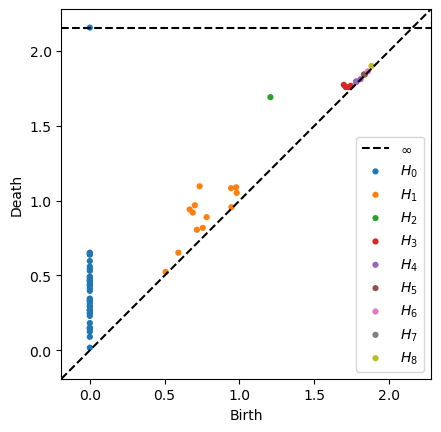

In [22]:
plot_diagrams(diagrams, show=True)

In [23]:
diagrams

[array([[0.        , 0.01737412],
        [0.        , 0.08986974],
        [0.        , 0.12428085],
        [0.        , 0.14127208],
        [0.        , 0.14979352],
        [0.        , 0.15047252],
        [0.        , 0.18195675],
        [0.        , 0.22961727],
        [0.        , 0.24418578],
        [0.        , 0.24980028],
        [0.        , 0.26303965],
        [0.        , 0.26823804],
        [0.        , 0.2707715 ],
        [0.        , 0.29075551],
        [0.        , 0.29636416],
        [0.        , 0.3151747 ],
        [0.        , 0.3258639 ],
        [0.        , 0.33519495],
        [0.        , 0.33714533],
        [0.        , 0.3457478 ],
        [0.        , 0.39731833],
        [0.        , 0.41379941],
        [0.        , 0.43381697],
        [0.        , 0.43406606],
        [0.        , 0.44580698],
        [0.        , 0.46147129],
        [0.        , 0.46396312],
        [0.        , 0.47065115],
        [0.        , 0.4774113 ],
        [0.   

# Persistent Homology 7 : 

## Maximum number of points : 50

In [24]:
dist_matrix = _compute_distance_matrix(PH_7_giving_50_points, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=7)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 59.65614652633667


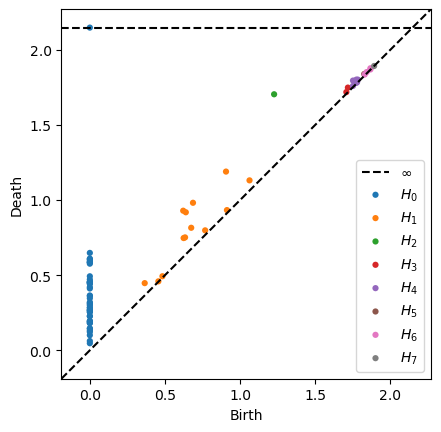

In [25]:
plot_diagrams(diagrams, show=True)

In [26]:
diagrams

[array([[0.        , 0.04685339],
        [0.        , 0.06189556],
        [0.        , 0.10035397],
        [0.        , 0.12217258],
        [0.        , 0.13111068],
        [0.        , 0.14487791],
        [0.        , 0.14534335],
        [0.        , 0.18046479],
        [0.        , 0.18220708],
        [0.        , 0.19049077],
        [0.        , 0.19237718],
        [0.        , 0.19557467],
        [0.        , 0.22652304],
        [0.        , 0.22760506],
        [0.        , 0.25452507],
        [0.        , 0.25549531],
        [0.        , 0.26611668],
        [0.        , 0.26739001],
        [0.        , 0.26830634],
        [0.        , 0.28236547],
        [0.        , 0.28386515],
        [0.        , 0.29823187],
        [0.        , 0.30715796],
        [0.        , 0.31402978],
        [0.        , 0.3199662 ],
        [0.        , 0.34595585],
        [0.        , 0.360589  ],
        [0.        , 0.36487195],
        [0.        , 0.41116744],
        [0.   

# Persistent Homology 6 : 

## Maximum number of points : 55

In [27]:
dist_matrix = _compute_distance_matrix(PH_6_giving_55_points, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=6)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 74.31594061851501


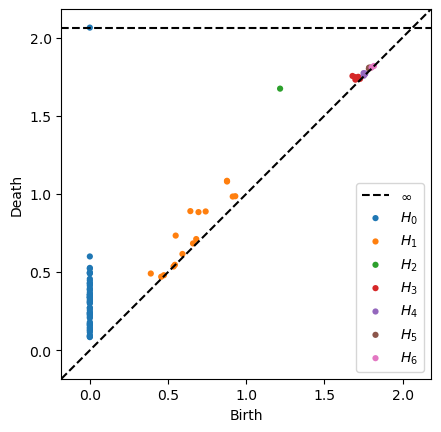

In [28]:
plot_diagrams(diagrams, show=True)

In [29]:
diagrams

[array([[0.        , 0.08416543],
        [0.        , 0.08748634],
        [0.        , 0.09136679],
        [0.        , 0.09651409],
        [0.        , 0.11461073],
        [0.        , 0.1244961 ],
        [0.        , 0.1311487 ],
        [0.        , 0.13970214],
        [0.        , 0.1466922 ],
        [0.        , 0.15897308],
        [0.        , 0.16235892],
        [0.        , 0.16948375],
        [0.        , 0.17146958],
        [0.        , 0.18006404],
        [0.        , 0.20597391],
        [0.        , 0.21370962],
        [0.        , 0.22469306],
        [0.        , 0.230856  ],
        [0.        , 0.23467816],
        [0.        , 0.23969549],
        [0.        , 0.24254937],
        [0.        , 0.2579332 ],
        [0.        , 0.27103457],
        [0.        , 0.27205348],
        [0.        , 0.29929599],
        [0.        , 0.30618629],
        [0.        , 0.30791485],
        [0.        , 0.31460491],
        [0.        , 0.32339138],
        [0.   

# Persistent Homology 5 : 

## Maximum number of points : 70

In [ ]:
dist_matrix = _compute_distance_matrix(PH_5_giving_70_points, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=5)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

In [ ]:
diagrams

# Persistent Homology 4 : 

## Maximum number of points : 118

In [ ]:
dist_matrix = _compute_distance_matrix(PH_4_giving_118_points, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=4)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

In [ ]:
diagrams

# Persistent Homology 3 : 

## Maximum number of points : 229

In [ ]:
random_pts = random_sampling_from_pt_cloud(point_data, 229)

dist_matrix = _compute_distance_matrix(random_pts, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=3)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

In [ ]:
diagrams

# Persistent Homology 2 : 

## Maximum number of points : 652

In [ ]:
random_pts = random_sampling_from_pt_cloud(point_data, 652)

dist_matrix = _compute_distance_matrix(random_pts, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

In [ ]:
diagrams

# Persistent Homology 1 : 

## Maximum number of points : 6800

In [ ]:
random_pts = random_sampling_from_pt_cloud(point_data, 6800)

dist_matrix = _compute_distance_matrix(random_pts, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=1)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

# Persistent Homology 0 : 

## Maximum number of points : 10000

In [ ]:
random_pts = random_sampling_from_pt_cloud(point_data, 6800)

dist_matrix = _compute_distance_matrix(random_pts, p=2)

start = time.time()

diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=0)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
plot_diagrams(diagrams, show=True)

229 random points on sphere : PH 3

652 random points on sphere : PH 2

6800 random points on sphere : PH 1

10000 random points on sphere : PH 0